In [24]:
import os
import cv2
import numpy as np
import time
import pandas as pd
import tracemalloc
import matplotlib.pyplot as plt
import shutil

TEST_IMAGES = [
    os.path.join("NIH-NLM-ThinBloodSmearsPf", "Polygon Set", "209C68P29N_ThinF", "Img", "IMG_20150819_133236.jpg"),
    os.path.join("NIH-NLM-ThinBloodSmearsPf", "Polygon Set", "231C89P50ThinF", "Img", "IMG_20150820_162153.jpg"),
    os.path.join("NIH-NLM-ThinBloodSmearsPf", "Polygon Set", "306C213ThinF", "Img", "IMG_20151106_112252.jpg"),
    os.path.join("NIH-NLM-ThinBloodSmearsPf", "Polygon Set", "362C177P138NThinF", "Img", "IMG_20151201_142846.jpg"),
    os.path.join("NIH-NLM-ThinBloodSmearsPf", "Polygon Set", "156C55P16thinF", "Img", "IMG_20150728_123237.jpg")
]

# Segmentation RAM and Time Evaluation

In [2]:
def get_channel(img_rgb, mode='green'):
    """ CLAHE + Invert Green """
    if mode == 'green':
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        g_c = clahe.apply(img_rgb[:, :, 1])
        green_inverted = 255 - g_c
        gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
        _, roi_mask = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY)
        img_green = cv2.bitwise_and(green_inverted, green_inverted, mask=roi_mask)
        return img_green
    return cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

In [3]:
def get_watershed_candidates(img_rgb, params):
    img_proc = get_channel(img_rgb, mode='green')
    
    blur_ksize = params.get('blur_ksize', 0)
    morph_kernel_size = params.get('morph_kernel_size', 3)
    dist_mask_size = params.get('dist_mask_size', 5)
    dist_thresh_ratio = params.get('dist_thresh_ratio', 0.5)
    min_area = params.get('min_area', 50)
    
    if blur_ksize > 0:
        k = blur_ksize if blur_ksize % 2 != 0 else blur_ksize + 1
        img_input = cv2.GaussianBlur(img_proc, (k, k), 0)
    else:
        img_input = img_proc
        
    valid_pixels = img_input[img_input > 0]
    if len(valid_pixels) == 0: return []
    
    otsu_thresh, _ = cv2.threshold(valid_pixels, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, binary = cv2.threshold(img_input, otsu_thresh, 255, cv2.THRESH_BINARY)
    
    kernel = np.ones((morph_kernel_size, morph_kernel_size), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, dist_mask_size)
    
    if dist_transform.max() == 0: return []
    _, sure_fg = cv2.threshold(dist_transform, dist_thresh_ratio * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    
    unknown = cv2.subtract(sure_bg, sure_fg)
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    markers = cv2.watershed(img_rgb, markers)
    
    unique, counts = np.unique(markers, return_counts=True)
    valid_labels = [l for l, c in zip(unique, counts) if l > 1 and c > min_area]
    candidates = []

    full_mask = np.isin(markers, valid_labels).astype(np.uint8) * 255
    contours, _ = cv2.findContours(full_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for cnt in contours:
        cv2.drawContours(full_mask, [cnt], -1, 255, -1)
        x, y, w, h = cv2.boundingRect(cnt)
        candidates.append({'cnt': cnt, 'rect': (x, y, w, h)})
        
    return candidates

def get_hough_candidates(img_rgb, params):
    img_proc = get_channel(img_rgb, mode='green')
    
    blur_ksize = params.get('blur_ksize', 5)
    dp = params.get('dp', 1.2)
    minDist = params.get('minDist', 35)
    param1 = params.get('param1', 50)
    param2 = params.get('param2', 30)
    min_radius = params.get('min_radius', 15)
    max_radius = params.get('max_radius', 80)
    
    if blur_ksize > 0:
        k = blur_ksize if blur_ksize % 2 != 0 else blur_ksize + 1
        blur = cv2.medianBlur(img_proc, k)
    else:
        blur = img_proc
    
    circles = cv2.HoughCircles(
        blur, cv2.HOUGH_GRADIENT, dp=dp, minDist=minDist,
        param1=param1, param2=param2, minRadius=min_radius, maxRadius=max_radius
    )
    
    candidates = []
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for c in circles[0, :]:
            cx, cy, r = int(c[0]), int(c[1]), int(c[2])
            
            side = int(r * 2.2) 
            x = max(0, int(cx - side//2))
            y = max(0, int(cy - side//2))
            w, h = side, side
            
            theta = np.linspace(0, 2*np.pi, 20)
            cnt_x = cx + r * np.cos(theta)
            cnt_y = cy + r * np.sin(theta)
            cnt = np.column_stack((cnt_x, cnt_y)).astype(np.int32)
            
            candidates.append({'cnt': cnt, 'rect': (x, y, w, h)})
            
    return candidates

In [4]:
FINAL_CONFIG = {
    "Watershed": {
        "func": get_watershed_candidates, 
        "params": {"blur_ksize": 0, "dist_mask_size": 3, "dist_thresh_ratio": 0.2, "min_area": 75}
    },
    "Hough": {
        "func": get_hough_candidates, 
        "params": {"blur_ksize": 5, "param1": 50, "param2": 35, "min_radius": 50, "max_radius": 90}
    }
}

In [33]:
def get_dir_size_mb(path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size / (1024 * 1024)

def run_inference_simulation(img_path, method_name, config, scale_factor=1.0, temp_root="Benchmark_Temp"):
    stream = np.fromfile(img_path, dtype=np.uint8)
    img = cv2.imdecode(stream, cv2.IMREAD_COLOR)
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img_name = os.path.splitext(os.path.basename(img_path))[0]
    save_dir = os.path.join(temp_root, method_name, img_name)
    
    if os.path.exists(save_dir):
        shutil.rmtree(save_dir)
    os.makedirs(save_dir, exist_ok=True)
    
    if scale_factor != 1.0:
        h, w = img_rgb.shape[:2]
        img_rgb = cv2.resize(img_rgb, (int(w * scale_factor), int(h * scale_factor)))
    
    candidates = config['func'](img_rgb, config['params'])
    
    count = 0
    for i, item in enumerate(candidates):
        if isinstance(item, dict):
            x, y, w, h = item['rect']
        else:
            x, y, w, h = item
            
        x1, y1 = max(0, x), max(0, y)
        x2, y2 = min(img_rgb.shape[1], x+w), min(img_rgb.shape[0], y+h)
        
        crop = img_rgb[y1:y2, x1:x2].copy()
        
        if crop.size > 0:
            crop_resized = cv2.resize(crop, (64, 64))
            save_path = os.path.join(save_dir, f"cell_{i}.jpg")
            cv2.imwrite(save_path, cv2.cvtColor(crop_resized, cv2.COLOR_RGB2BGR))
            count += 1
            
    return count, save_dir

def benchmark_method(img_paths, method_name, config, scale=1.0):
    timings = []
    memories = []
    disk_usages = []
    counts = []
    
    temp_root = "Benchmark_Temp"
    
    for path in img_paths:
        tracemalloc.start()
        start_time = time.perf_counter()
        
        n_cells, output_dir = run_inference_simulation(path, method_name, config, scale_factor=scale, temp_root=temp_root)
        
        end_time = time.perf_counter()
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        
        disk_mb = get_dir_size_mb(output_dir)
        
        timings.append(end_time - start_time)
        memories.append(peak / (1024 * 1024))
        disk_usages.append(disk_mb)
        counts.append(n_cells)
        
        if os.path.exists(output_dir):
            shutil.rmtree(output_dir)
            
    return {
        "AvgTime (sec)": np.mean(timings),
        "MaxTime (sec)": np.max(timings),
        "AvgPeakRAM (MB)": np.mean(memories),
        "AvgStorage (MB)": np.mean(disk_usages),
        "AvgCellsNumber": np.mean(counts)
    }

In [34]:
results = []

for method_name, config in FINAL_CONFIG.items():
    stats = benchmark_method(TEST_IMAGES, method_name, config, scale=1.0)
    stats['Method'] = method_name
    stats['Scale'] = 1.0
    results.append(stats)

df_bench = pd.DataFrame(results)
df_bench = df_bench[['Method', 'Scale', "MaxTime (sec)", 'AvgTime (sec)', 'AvgPeakRAM (MB)', 'AvgStorage (MB)', 'AvgCellsNumber']]

print(df_bench.round(2).to_string(index=False))


   Method  Scale  MaxTime (sec)  AvgTime (sec)  AvgPeakRAM (MB)  AvgStorage (MB)  AvgCellsNumber
Watershed    1.0           1.29           1.11           403.07             0.30           194.0
    Hough    1.0           1.27           1.03           168.77             0.45           295.6


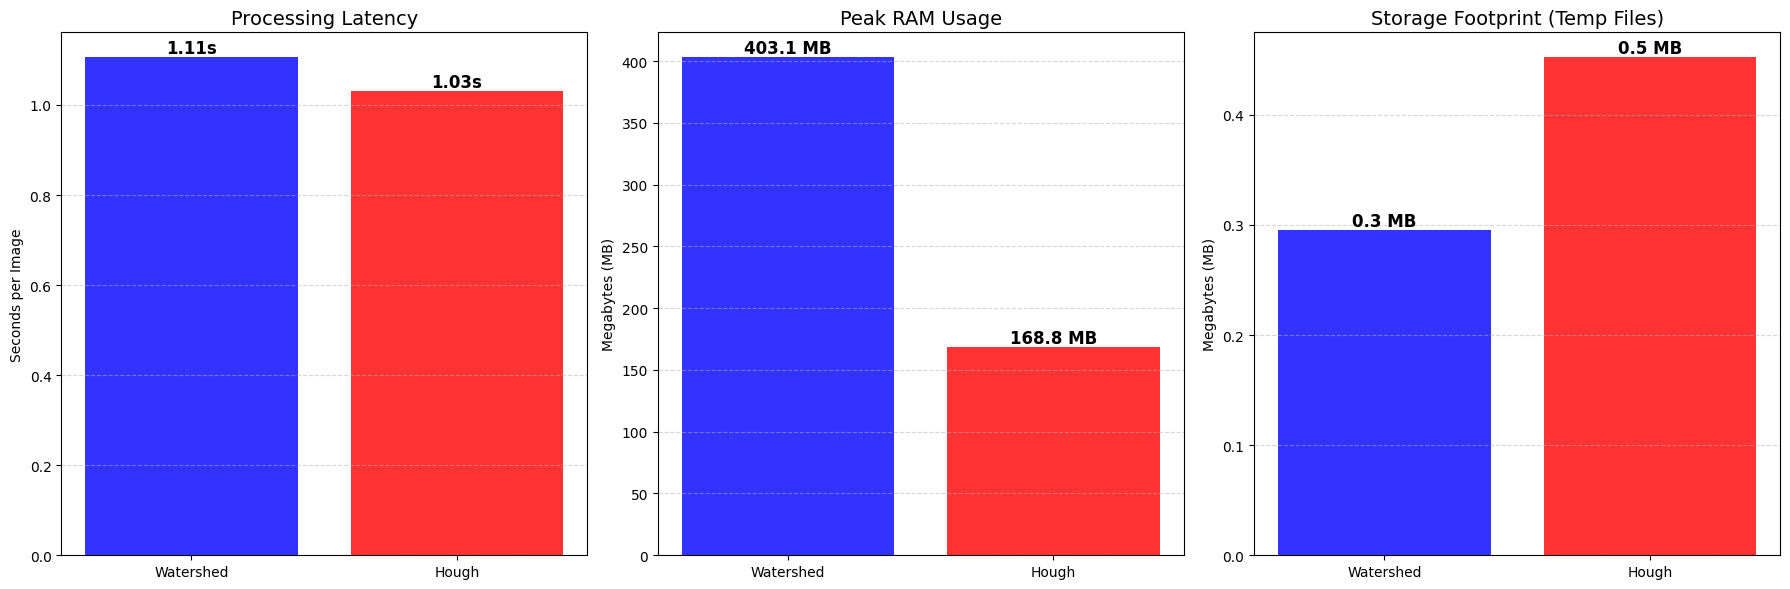

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

methods = df_bench['Method']
colors = ['blue', 'red']

bars1 = axes[0].bar(methods, df_bench['AvgTime (sec)'], color=colors, alpha=0.8)
axes[0].set_title("Processing Latency", fontsize=14)
axes[0].set_ylabel("Seconds per Image")
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}s', ha='center', va='bottom', fontsize=12, fontweight='bold')

bars2 = axes[1].bar(methods, df_bench['AvgPeakRAM (MB)'], color=colors, alpha=0.8)
axes[1].set_title("Peak RAM Usage", fontsize=14)
axes[1].set_ylabel("Megabytes (MB)")
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.1f} MB', ha='center', va='bottom', fontsize=12, fontweight='bold')

bars3 = axes[2].bar(methods, df_bench['AvgStorage (MB)'], color=colors, alpha=0.8)
axes[2].set_title("Storage Footprint (Temp Files)", fontsize=14)
axes[2].set_ylabel("Megabytes (MB)")
axes[2].grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars3:
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.1f} MB', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()